### Importing Libraries:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords

### Importing dataset :

In [2]:
train_news = pd.read_csv('data/train.csv.zip', index_col = False)
test_news = pd.read_csv('data/test.csv.zip', index_col = None)

### Resulting dataframe

In [3]:
train_news.drop('id', axis = 1)

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


### Dataset Exploration

In [4]:
train_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [5]:
train_news.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [6]:
train_news.dtypes

id         int64
title     object
author    object
text      object
label      int64
dtype: object

#### Is the dataset balanced?

In [7]:
train_news.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

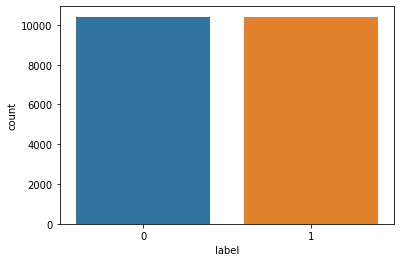

In [8]:
sns.countplot(train_news['label'])

In [9]:
train_news['duplicate'] = train_news.duplicated(subset=['text'])

In [10]:
train_news.groupby(['duplicate', 'label']).label.count()

duplicate  label
False      0        10387
           1        10000
True       1          413
Name: label, dtype: int64

In [11]:
"""The dataset is balanced and there are almost no duplicates, also, the data types are correct. 
There are several null values that we must take a look into"""

'The dataset is balanced and there are almost no duplicates, also, the data types are correct. \nThere are several null values that we must take a look into'

### Dropping duplicates 

In [44]:
train_news.loc[train_news['duplicate'] == True]

,id,title,author,text,label,duplicate
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,Mohamad Khweis: Another “Virginia Man” (Palest...,1,True
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,A Connecticut Reader Reports Record Voter Regi...,1,True
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,BULLETIN: There ARE Righteous Jews For Trump!;...,1,True
480,480,Watch: Muslim ‘Palestinians’ Declare “We follo...,admin,Watch: Muslim ‘Palestinians’ Declare “We follo...,1,True
592,592,Is your promising internet career over now Vin...,newsbiscuit editorial team,Is your promising internet career over now Vin...,1,True
...,...,...,...,...,...,...
20728,20728,Trump warns of World War III if Clinton is ele...,Anonymous,Trump warns of World War III if Clinton is ele...,1,True
20749,20749,Realities Faced by Black Canadians are a Natio...,Anonymous,Realities Faced by Black Canadians are a Natio...,1,True
20750,20750,Why Did Four Googles Kill This White?,Andrew Anglin,Why Did Four Googles Kill This White?Migrant C...,1,True
20754,20754,No More American Thanksgivings,Glen Ford,No More American ThanksgivingsThanksgiving by ...,1,True


In [48]:
train_news = train_news.drop((train_news.loc[train_news['duplicate'] == True].index))

#### Treating Null Values

In [12]:
train_news.isnull().sum()

id              0
title         558
author       1957
text           39
label           0
duplicate       0
dtype: int64

In [13]:
train_news.loc[train_news['text'].isnull()]

,id,title,author,text,label,duplicate
142,142,Gorafi Magazine : Entretien exclusif avec Bara...,NaN,NaN,1,False
573,573,Le top des recherches Google passe en top des ...,NaN,NaN,1,True
1200,1200,La Corée du Nord annonce avoir envoyé un missi...,NaN,NaN,1,True
1911,1911,Grand-Prix du Brésil – Romain Grosjean obtient...,NaN,NaN,1,True
2148,2148,Gorafi Magazine: Barack Obama « Je vous ai déj...,NaN,NaN,1,True
2169,2169,"#NDDL: Pour fêter l’autorisation des travaux, ...",NaN,NaN,1,True
2793,2793,«Pourquoi je suis candidat à la présidentielle...,NaN,NaN,1,True
3329,3329,GuinessBook : 100 millions d’Américains batten...,NaN,NaN,1,True
3729,3729,Les Américains ne sont plus qu’à quelques heur...,NaN,NaN,1,True
4288,4288,Hillary Clinton en 5 dates >> Le Gorafi,NaN,NaN,1,True


All this news have no text or author + they are in french, which would make our algorithm to work innacurately since most of our news are in english. We will then drop this rows. 

In [14]:
train_news = train_news.drop((train_news.loc[train_news['text'].isnull()].index).copy())

In [15]:
train_news.loc[train_news['author'].isnull()]

,id,title,author,text,label,duplicate
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,False
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,False
20,20,News: Hope For The GOP: A Nude Paul Ryan Has J...,NaN,Email \nSince Donald Trump entered the electio...,1,False
23,23,Massachusetts Cop’s Wife Busted for Pinning Fa...,NaN,Massachusetts Cop’s Wife Busted for Pinning Fa...,1,False
31,31,Israel is Becoming Pivotal to China’s Mid-East...,NaN,Country: Israel While China is silently playin...,1,False
...,...,...,...,...,...,...
20718,20718,This Is The Best Picture In Human History | Da...,NaN,This Is The Best Picture In Human History By: ...,1,False
20728,20728,Trump warns of World War III if Clinton is ele...,NaN,Email Donald Trump warned in an interview Tues...,1,True
20745,20745,Thomas Frank Explores Whether Hillary Clinton ...,NaN,Thomas Frank Explores Whether Hillary Clinton ...,1,False
20768,20768,Osama bin Laden’s older brother rents out luxu...,NaN,Osama bin Laden’s older brother rents out luxu...,1,False


In [16]:
"""The author column is not on our other dataset, so it should be too important, however we are going to 
see if the Fake News are the ones without author"""

'The author column is not on our other dataset, so it should be too important, however we are going to \nsee if the Fake News are the ones without author'

In [17]:
train_news.loc[train_news['author'].isnull()]['label'].value_counts()

1    1892
0      26
Name: label, dtype: int64

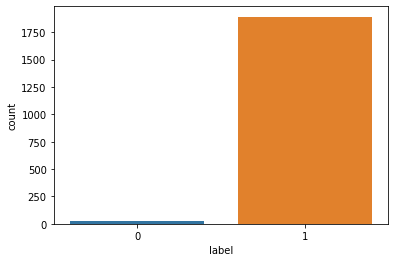

In [18]:
sns.countplot(train_news.loc[train_news['author'].isnull()]['label'])

In [19]:
'''Most of the news that have not an author are fake. So instead dropping this lines, we are going to replace them 
with the value Anonymous, since it could be a key column for our algorithm'''

'Most of the news that have not an author are fake. So instead dropping this lines, we are going to replace them \nwith the value Anonymous, since it could be a key column for our algorithm'

In [25]:
train_news['author'] = train_news['author'].replace(np.nan, 'Anonymous').copy()

In [26]:
train_news.isnull().sum()

id             0
title        558
author         0
text           0
label          0
duplicate      0
dtype: int64

Last, we have to treat the null values from the title. Let's check out how many rows also come from an Anonymous source. In that case, we will drop them because the information provided originally was too little. 
Otherwise, we won't drop them since the title and the text are going to be analized together.

In [28]:
train_news.loc[(train_news['title'].isnull()) & (train_news['author'] == 'Anonymous')]

,id,title,author,text,label,duplicate
120,120,NaN,Anonymous,"Same people all the time , i dont know how you...",1,False
140,140,NaN,Anonymous,There is a lot more than meets the eye to this...,1,False
562,562,NaN,Anonymous,Field is correct about the 8a companies and Tr...,1,False
1292,1292,NaN,Anonymous,"Same people all the time , i dont know how you...",1,True
1322,1322,NaN,Anonymous,Georg Soros the good oil . http://mailstar.net...,1,False
...,...,...,...,...,...,...
17780,17780,NaN,Anonymous,The second video (bottom one ) proves what Tru...,1,True
18109,18109,NaN,Anonymous,yOU HAVE TO DRAW THE LINE SOMEWHERE AND CHILD ...,1,True
18720,18720,NaN,Anonymous,There is plenty of proof the machines are rigg...,1,True
18903,18903,NaN,Anonymous,"There are lots of diiferent truths , when i he...",1,False


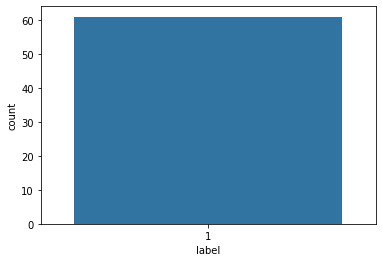

In [29]:
sns.countplot(train_news.loc[(train_news['title'].isnull()) & (train_news['author'] == 'Anonymous')]['label'])

In [39]:
#dropping these rows

train_news = train_news.drop((train_news.loc[(train_news['title'].isnull()) & (train_news['author'] == 'Anonymous')].index))

In [40]:
train_news.isnull().sum()

id             0
title        497
author         0
text           0
label          0
duplicate      0
dtype: int64

In [42]:
train_news['text'] = train_news['title'] + train_news['text']

### Resulting dataset

In [51]:
train_news = train_news.drop(['id', 'title','duplicate'], axis=1)

In [52]:
train_news.head()

,author,text,label
0,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,Daniel J. Flynn,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Consortiumnews.com,Why the Truth Might Get You FiredWhy the Truth...,1
3,Jessica Purkiss,15 Civilians Killed In Single US Airstrike Hav...,1
4,Howard Portnoy,Iranian woman jailed for fictional unpublished...,1
